In [1]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from openpyxl import load_workbook
pd.set_option('future.no_silent_downcasting',True)

In [2]:
#Read xlsx sheet and carry out some basic filtering / clean up
def load_spreadsheet(sheet_name):
    #skipping information rows at top of table, these are typical in datasets from Te Whatu Ora (Health New Zealand)
    df = pd.read_excel('Cancer/cancer-historical-summary-1948-2020.xlsx', sheet_name, skiprows=[0,1,2,4])
    df.dropna(subset='Brain (C71)', inplace=True)
    #have found it necessary to create the 'Year' column a second time, as for some reason when dropping unnamed columns it would set all 'Year' values to NAN 
    #if I took approach of simply renaming 'Unnamed: 0' to 'Year'
    df.insert(loc=0, column='Year', value=df['Unnamed: 0'])
    df.drop(df.filter(regex='Unnamed').columns, axis=1, inplace=True)
    df = df.fillna(0) 
    return df

In [3]:
#Titles of the various sheets in the xlsx file
sheets_to_load = {'Regs_Total':None,'Deaths_Total':None,'Regs_Male':None,'Regs_Female':None,'Deaths_Male':None,'Deaths_Female':None}

In [4]:
#populate dictionary containing dataframe for each sheet
dfd = {}
for name in sheets_to_load:
    dfd[name] = pd.DataFrame(load_spreadsheet(name))
df_pop = pd.read_csv('Cancer/nzpopulation.csv')

In [5]:
#'releasing' dataframes from dictionary
for sheet in sheets_to_load:
    globals()[sheet] = dfd[sheet]

In [6]:
%whos DataFrame

Variable        Type         Data/Info
--------------------------------------
Deaths_Female   DataFrame        Year All cancers (C00<...>n\n[66 rows x 23 columns]
Deaths_Male     DataFrame        Year All cancers (C00<...>n\n[66 rows x 20 columns]
Deaths_Total    DataFrame        Year All cancers (C00<...>n\n[66 rows x 18 columns]
Regs_Female     DataFrame        Year  All cancers (C0<...>n\n[73 rows x 23 columns]
Regs_Male       DataFrame        Year  All cancers (C0<...>n\n[73 rows x 20 columns]
Regs_Total      DataFrame        Year  All cancers (C0<...>n\n[73 rows x 18 columns]
df_pop          DataFrame        year  population  mal<...>\n\n[76 rows x 5 columns]


In [7]:
#Example of the total registration file
Regs_Total.head()

,Year,"All cancers (C00–C96, D45–D47)","Lip, Oral Cavity and Pharynx (C00–C14)",Oesophagus (C15),Stomach (C16),Colorectum and anus (C18–C21),Liver and intrahepatic bile ducts (C22),Pancreas (C25),Lung & Trachea (C33–C34),Melanoma (C43),"Kidney and other urinary (C64–C66, C68)",Bladder (C67),Brain (C71),Thyroid (C73),Hodgkin lymphoma (C81),"Non-Hodgkin lymphoma (C82–C86, C96)",Myeloma (C90),Leukaemia (C91–C95)
0,1948,3474.0,251.0,53.0,305.0,448.0,39.0,74.0,156.0,51.0,44.0,75.0,43.0,16.0,23.0,66.0,12.0,97.0
1,1949,3675.0,233.0,51.0,321.0,401.0,38.0,93.0,153.0,37.0,41.0,84.0,56.0,18.0,32.0,77.0,8.0,83.0
2,1950,3605.0,224.0,46.0,352.0,409.0,50.0,95.0,175.0,39.0,43.0,79.0,56.0,19.0,44.0,71.0,9.0,97.0
3,1951,3787.0,204.0,59.0,294.0,439.0,43.0,108.0,201.0,66.0,72.0,77.0,65.0,17.0,31.0,105.0,13.0,90.0
4,1952,3968.0,242.0,75.0,319.0,469.0,58.0,86.0,231.0,64.0,61.0,74.0,69.0,25.0,31.0,82.0,16.0,81.0


In [8]:
#To obtain total number of cases in a given period
def Sum_of_Period(df,min_year,max_year):
    df = df[(df['Year'] > min_year) & (df['Year'] <= max_year)]
    df = df.drop('Year', axis = 1)
    df = df.astype(int)
    df = df.sum()
    return df

In [9]:
#Joining multiple dataframes which are utilising Sum_of_Period
def Join_Comp_Sum(d1,d2,col1,col2,min_year,max_year):
    df1 = pd.DataFrame(Sum_of_Period(d1,min_year,max_year))
    df1 = df1.rename(columns={0: col1})
    df2 = pd.DataFrame(Sum_of_Period(d2,min_year,max_year))
    df1[col2] = df2[0]
    return df1

In [10]:
#Selecting period of time only from a dataframe
def Select_Period(df,min_year,max_year):
    df = df[(df['Year'] > min_year) & (df['Year'] <= max_year)]
    df = df.astype(int)
    return df

In [11]:
#Joining multiple dataframes which are utilising Select_Period only
def Join_Comp(d1,d2,col1,col2,min_year,max_year):
    df1 = pd.DataFrame(Select_Period(d1,min_year,max_year))
    df1 = df1.rename(columns={df1.columns[1]: col1})
    df2 = Select_Period(d2,min_year,max_year)
    df2 = df2.rename(columns={df2.columns[1]: col2})
    df2 = df2.drop('Year', axis = 1)
    df1 = pd.concat([df1, df2], axis=1)
    return df1

In [12]:
femaleR_to_add = Regs_Female[(Regs_Female.columns.difference(Regs_Total.columns)).tolist()]
femaleD_to_add = Deaths_Female[(Deaths_Female.columns.difference(Deaths_Total.columns)).tolist()]

In [13]:
maleR_to_add = Regs_Male[(Regs_Male.columns.difference(Regs_Total.columns)).tolist()]
maleD_to_add = Deaths_Male[(Deaths_Male.columns.difference(Deaths_Total.columns)).tolist()]

In [14]:
comp_Regs = pd.concat([Regs_Total, femaleR_to_add, maleR_to_add], axis=1)
comp_Deaths = pd.concat([Deaths_Total, femaleD_to_add, maleD_to_add], axis=1)

In [15]:
#Obtaining the total numbers of deaths and registrations for each cancer type during the period 2008 - 2018
min_year = 2008
max_year = 2018
c1 = 'Regs_Total'
c2 = 'Deaths_Total'
compdf = Join_Comp_Sum(comp_Regs,comp_Deaths,c1,c2,min_year,max_year)
compdf = compdf.drop(index='All cancers (C00–C96, D45–D47)')

In [16]:
#Obtaining the total numbers of deaths and registrations for each cancer type during the period 2008 - 2018
min_year = 2008
max_year = 2018
c1 = 'Regs_Total'
c2 = 'Deaths_Total'
compdf = Join_Comp_Sum(comp_Regs,comp_Deaths,c1,c2,min_year,max_year)
compdf = compdf.drop(index='All cancers (C00–C96, D45–D47)')

In [17]:
compdf

,Regs_Total,Deaths_Total
"Lip, Oral Cavity and Pharynx (C00–C14)",4646,1354
Oesophagus (C15),2886,2413
Stomach (C16),3902,2790
Colorectum and anus (C18–C21),31085,12486
Liver and intrahepatic bile ducts (C22),3304,2514
Pancreas (C25),5487,4792
Lung & Trachea (C33–C34),21770,17022
Melanoma (C43),24080,3444
"Kidney and other urinary (C64–C66, C68)",6289,2275
Bladder (C67),3956,2132


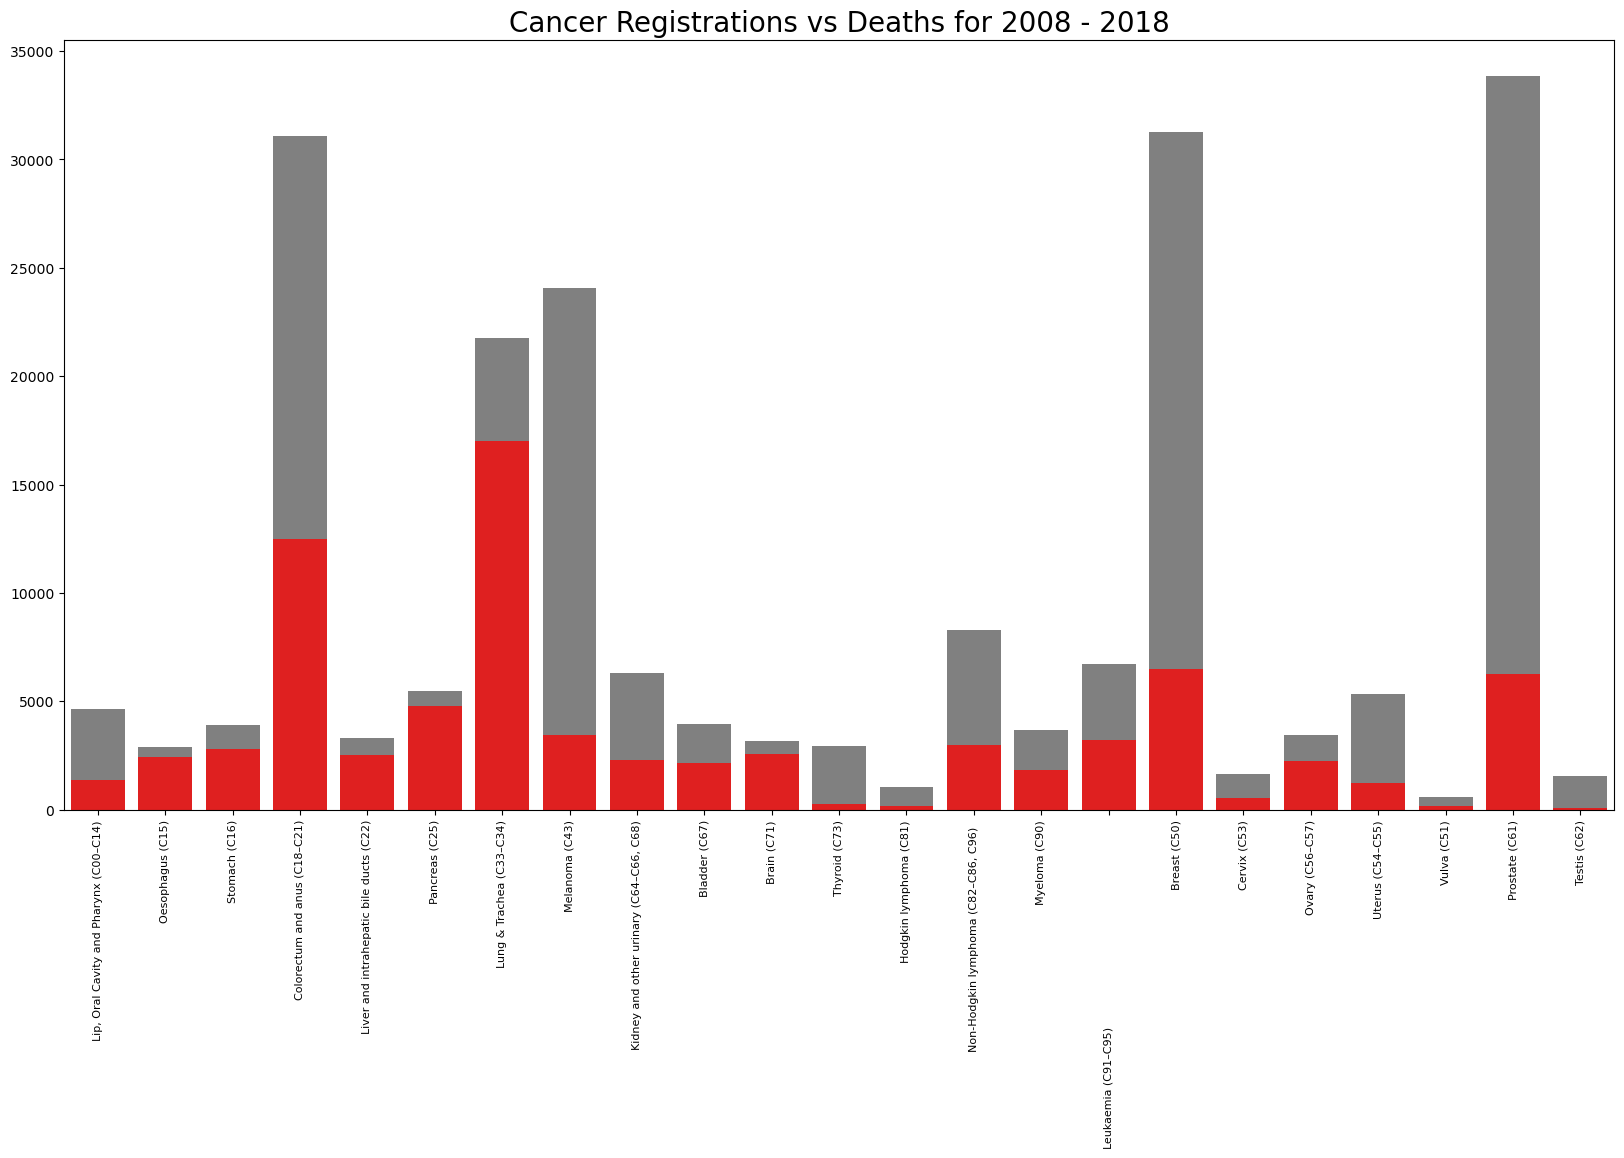

In [18]:
#plotting deaths vs registrations using the above dataframe - will not entirely reflect cancer survival rate per registered case due to potential time after registration to final outcome (common theme in this exploration)
#Pretty impactful chart for me to see, it does suggest that for the most common cancers, treatment is quite effective, with the exception of Lung & Trachea and to a lesser degree Rectum & Anus, I also had no idea that
#breast and prostate cancer were quite so prevalent 
#Unsure why Leukaemia x label has dropped off the bottom of the chart
fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=90,fontsize=8)
sns.barplot(data=compdf,x=compdf.index,y='Regs_Total',errorbar=None, color = 'grey')
sns.barplot(data=compdf,x=compdf.index,y='Deaths_Total',errorbar=None, color = 'red')
plt.xlabel('')
plt.ylabel('')
plt.title('Cancer Registrations vs Deaths for 2008 - 2018', fontsize = 20) 
plt.show(fig)

In [19]:
#Investigating cancer registrations and deaths over time
min_year = 1960
max_year = 2018
c1 = 'Regs_Total'
c2 = 'Deaths_Total'
RegsT = Regs_Total.loc[:, ['Year', 'All cancers (C00–C96, D45–D47)']] 
DeathsT = Deaths_Total.loc[:, ['Year', 'All cancers (C00–C96, D45–D47)']] 
compdf2 = Join_Comp(RegsT,DeathsT,c1,c2,min_year,max_year)
compdf2 = compdf2.rename(columns={1: 'Registrations', 2: 'Deaths'})
#adding NZ population figures to df to allow for check
df_pop_filt = df_pop[(df_pop['year'] > min_year) & (df_pop['year'] <= max_year)]
df_pop_filt = df_pop_filt.drop(['year','male : female ratio', 'male', 'female'], axis=1) 
compdf2 = pd.concat([compdf2, df_pop_filt], axis=1)
compdf2['Death_Rate'] = compdf2['Deaths_Total'] / compdf2['Regs_Total'] * 100
compdf2['Regs:Pop'] = compdf2['Regs_Total'] / compdf2['population'] * 100000
compdf2['Deaths:Pop'] = compdf2['Deaths_Total'] / compdf2['population'] * 100000
compdf2.head()


,Year,Regs_Total,Deaths_Total,population,Death_Rate,Regs:Pop,Deaths:Pop
13,1961,4432,3541,2431617,79.896209,182.265546,145.623262
14,1962,4546,3597,2486311,79.124505,182.841165,144.672167
15,1963,4760,3752,2540026,78.823529,187.399657,147.715023
16,1964,4887,3674,2590648,75.179046,188.640062,141.817800
17,1965,5140,3817,2638316,74.260700,194.821242,144.675619


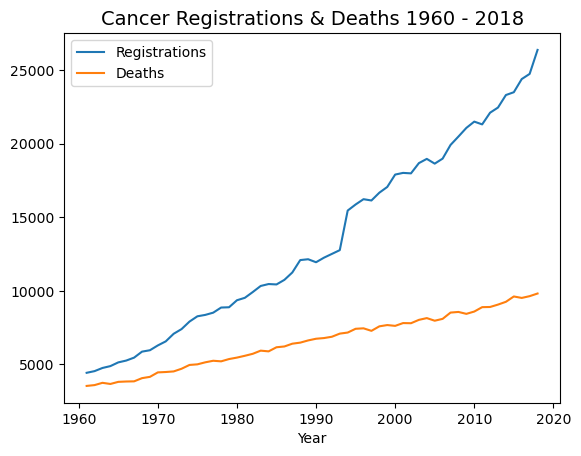

In [20]:
#Viewing cancer registrations and deaths over time, of interest is the spike in registrations in mid 90's 
#Is this due to new screening improvement or a change in the way cancer was registered in NZ?
sns.lineplot(data=compdf2, x='Year', y='Regs_Total', label='Registrations')
sns.lineplot(data=compdf2, x='Year', y='Deaths_Total', label='Deaths')
plt.legend()
plt.xlabel('Year')
plt.ylabel('')
plt.title('Cancer Registrations & Deaths 1960 - 2018', fontsize = 14) 
plt.show()


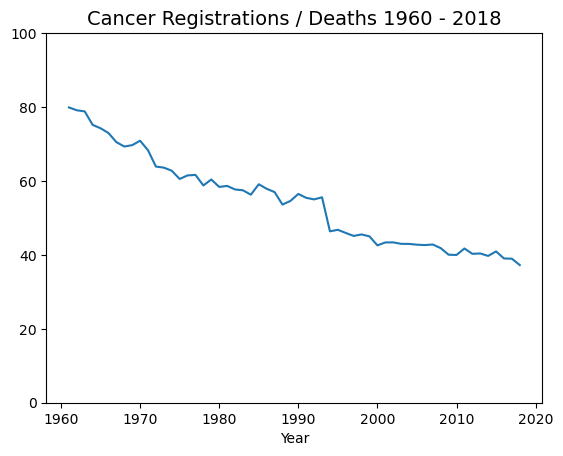

In [21]:
#Cancer deaths : registrations, while this is not accurate on a year by year basis
#it does indicate that overall the death rate has decreased, though improved screening / 
#change in the way cancer is registered will also reduce the death rate when compared to
#registrations
plt.ylim(0, 100)
sns.lineplot(data=compdf2, x='Year', y='Death_Rate')
plt.xlabel('Year')
plt.ylabel('')
plt.title('Cancer Registrations / Deaths 1960 - 2018', fontsize = 14) 
plt.show()

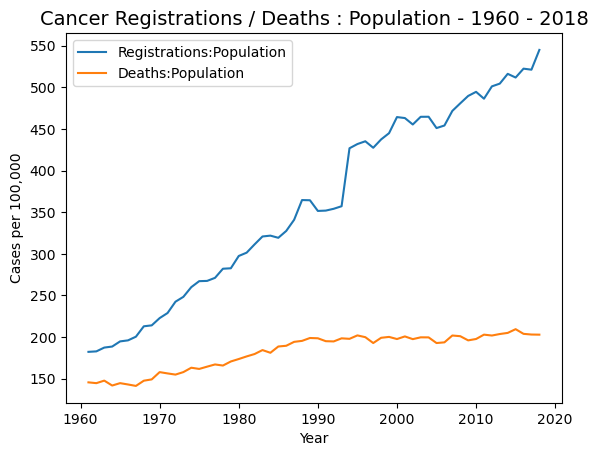

In [22]:
#Deaths per capita have largely stayed steady since 1990, would suggest that the lower
#death:registration ratio is largely due to improved screening (barring mid 1990 jump
#which I would hypothesise is due to change in way cancer is registered
sns.lineplot(data=compdf2, x='Year', y='Regs:Pop', label='Registrations:Population')
sns.lineplot(data=compdf2, x='Year', y='Deaths:Pop', label='Deaths:Population')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Cases per 100,000')
plt.title('Cancer Registrations / Deaths : Population - 1960 - 2018', fontsize = 14) 
plt.show()

In [23]:
#I would like to see this same data with male and female numbers included
to_add = Deaths_Male.loc[:, ['Year', 'All cancers (C00–C96, D45–D47)']] 
to_add = to_add.rename(columns={'All cancers (C00–C96, D45–D47)': 'Deaths_Male'})
deathsF = Deaths_Female.loc[:, ['Year', 'All cancers (C00–C96, D45–D47)']] 
deathsF = deathsF.rename(columns={'All cancers (C00–C96, D45–D47)': 'Deaths_Female'})
deathsF = deathsF.drop(['Year'], axis = 1)
regsM = Regs_Male.loc[:, ['Year','All cancers (C00–C96, D45–D47)']] 
regsM = regsM.rename(columns={'All cancers (C00–C96, D45–D47)': 'Regs_Male'})
regsM = regsM.drop(['Year'], axis = 1)
regsF = Regs_Female.loc[:, ['All cancers (C00–C96, D45–D47)']]
to_add = pd.concat([to_add, deathsF, regsM, regsF], axis=1)
to_add = Select_Period(to_add, min_year, max_year)
to_add = to_add.drop(['Year'], axis = 1)
to_add = to_add.rename(columns={'All cancers (C00–C96, D45–D47)': 'Regs_Female'})

In [24]:
to_add.head()

,Deaths_Male,Deaths_Female,Regs_Male,Regs_Female
13,1870,1671,2291,2141
14,1936,1661,2374,2172
15,2044,1708,2468,2292
16,1962,1712,2519,2368
17,2034,1783,2673,2467


In [25]:
compdf2 = pd.concat([compdf2, to_add], axis=1)

In [26]:
compdf2.head()

,Year,Regs_Total,Deaths_Total,population,Death_Rate,Regs:Pop,Deaths:Pop,Deaths_Male,Deaths_Female,Regs_Male,Regs_Female
13,1961,4432,3541,2431617,79.896209,182.265546,145.623262,1870,1671,2291,2141
14,1962,4546,3597,2486311,79.124505,182.841165,144.672167,1936,1661,2374,2172
15,1963,4760,3752,2540026,78.823529,187.399657,147.715023,2044,1708,2468,2292
16,1964,4887,3674,2590648,75.179046,188.640062,141.817800,1962,1712,2519,2368
17,1965,5140,3817,2638316,74.260700,194.821242,144.675619,2034,1783,2673,2467


In [27]:
compdf2['Male_Death_Rate'] = compdf2['Deaths_Male'] / compdf2['Regs_Male'] * 100
compdf2['Female_Death_Rate'] = compdf2['Deaths_Female'] / compdf2['Regs_Female'] * 100

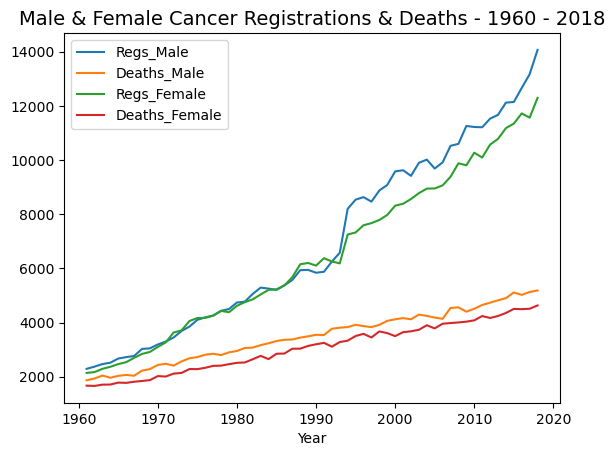

In [28]:
#Males seem to have a higher incidence rate of cancer overall 
sns.lineplot(data=compdf2, x='Year', y='Regs_Male', label = 'Regs_Male')
sns.lineplot(data=compdf2, x='Year', y='Deaths_Male', label = 'Deaths_Male')
sns.lineplot(data=compdf2, x='Year', y='Regs_Female', label = 'Regs_Female')
sns.lineplot(data=compdf2, x='Year', y='Deaths_Female', label = 'Deaths_Female')
plt.legend()
plt.xlabel('Year')
plt.ylabel('')
plt.title('Male & Female Cancer Registrations & Deaths - 1960 - 2018', fontsize = 14) 
plt.show()


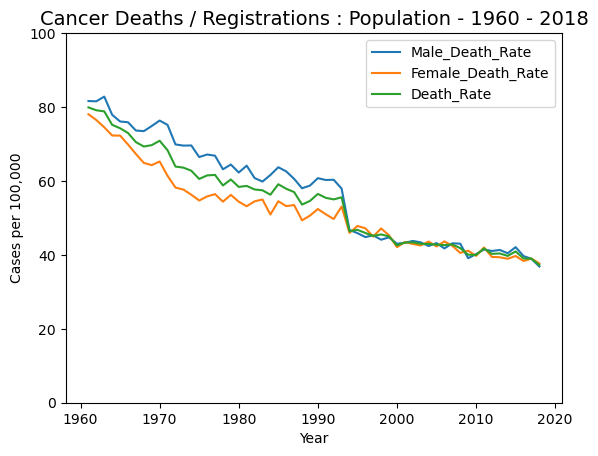

In [29]:
#While there are certainly still issues with using this method of obtaining death rate
#the tight correlation after early 1990s does seem to suggest a change in cancer registration
#or much improved screening (however as this would be over all cancers, I doubt there that
#were multiple screening improvements being brought in within such a small space of time. This
#is something I would like to follow up with and investigate
plt.ylim(0, 100)
sns.lineplot(data=compdf2, x='Year', y='Male_Death_Rate', label = 'Male_Death_Rate')
sns.lineplot(data=compdf2, x='Year', y='Female_Death_Rate', label = 'Female_Death_Rate')
sns.lineplot(data=compdf2, x='Year', y='Death_Rate', label = 'Death_Rate')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Cases per 100,000')
plt.title('Cancer Deaths / Registrations : Population - 1960 - 2018', fontsize = 14) 
plt.show()

In [30]:
def Filter_Cancer_Type(c1,c2,c3,min_year,max_year):
    RegsT = Regs_Total.loc[:, ['Year', c3]] 
    DeathsT = Deaths_Total.loc[:, ['Year', c3]] 
    compdf2 = Join_Comp(RegsT,DeathsT,c1,c2,min_year,max_year)
    compdf2 = compdf2.rename(columns={1: 'Registrations', 2: 'Deaths'})
    df_pop_filt = df_pop[(df_pop['year'] > min_year) & (df_pop['year'] <= max_year)]
    df_pop_filt = df_pop_filt.drop(['year','male : female ratio', 'male', 'female'], axis=1) 
    compdf2 = pd.concat([compdf2, df_pop_filt], axis=1)
    to_add = Deaths_Male.loc[:, ['Year', c3]] 
    to_add = to_add.rename(columns={c3: 'Deaths_Male'})
    deathsF = Deaths_Female.loc[:, ['Year', c3]] 
    deathsF = deathsF.rename(columns={c3: 'Deaths_Female'})
    deathsF = deathsF.drop(['Year'], axis = 1)
    regsM = Regs_Male.loc[:, ['Year',c3]] 
    regsM = regsM.rename(columns={c3: 'Regs_Male'})
    regsM = regsM.drop(['Year'], axis = 1)
    regsF = Regs_Female.loc[:, [c3]]
    to_add = pd.concat([to_add, deathsF, regsM, regsF], axis=1)
    to_add = Select_Period(to_add, min_year, max_year)
    to_add = to_add.drop(['Year'], axis = 1)
    to_add = to_add.rename(columns={c3: 'Regs_Female'})
    compdf2['Death_Rate'] = compdf2['Deaths_Total'] / compdf2['Regs_Total'] * 100
    compdf2['Regs:Pop'] = compdf2['Regs_Total'] / compdf2['population'] * 100000
    compdf2['Deaths:Pop'] = compdf2['Deaths_Total'] / compdf2['population'] * 100000
    compdf2 = pd.concat([compdf2, to_add], axis=1)
    compdf2['Male_Death_Rate'] = compdf2['Deaths_Male'] / compdf2['Regs_Male'] * 100
    compdf2['Female_Death_Rate'] = compdf2['Deaths_Female'] / compdf2['Regs_Female'] * 100
    return compdf2


In [31]:
#Lung & Trachea, choosing these as an example as these seem to be the most fatal (by total cases) form of cancers
#I have used the Fitler_Cancer_Type function above to select the desired columns from different dataframes and then 
#create some additional columns
#This would be much easier to do with SQL and were I to want to obtain these results again, I would use a database
#and form my final dataframes using SQL queries, then use python to do analysis work. I am aware this could have been
#done in a more timely manner, however, I wished to follow this particular rabbithole 
min_year = 1960
max_year = 2018
c1 = 'Regs_Total'
c2 = 'Deaths_Total'
c3 = 'Lung & Trachea (C33–C34)'

LungTrach = Filter_Cancer_Type(c1,c2,c3,min_year,max_year)

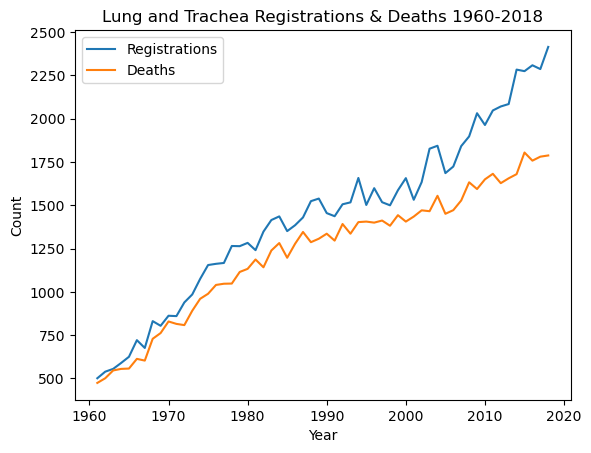

In [32]:
#Plotting registrations and deaths by year for Lung & Trachea cancers
sns.lineplot(data=LungTrach, x='Year', y='Regs_Total', label='Registrations')
sns.lineplot(data=LungTrach, x='Year', y='Deaths_Total', label='Deaths')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Lung and Trachea Registrations & Deaths 1960-2018") 
plt.show()

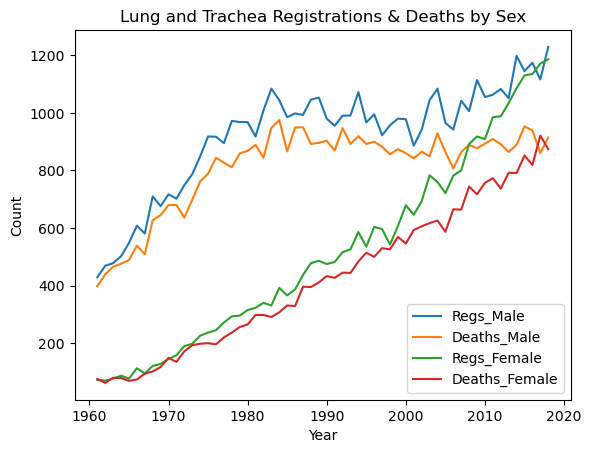

In [33]:
#Lung and Trachea registrations & deaths per year by sex, further investigation could be done into
#why female registrations have spiked while male registrations have increased at a lower rate 
#While male deaths have remained steady, female death rates have continuously increased
#This may indicate a change in behaviour, potentially in both sexes, I would be interested
#in looking at smoking trends in different demographics & sexes within those demographics
sns.lineplot(data=LungTrach, x='Year', y='Regs_Male', label = 'Regs_Male')
sns.lineplot(data=LungTrach, x='Year', y='Deaths_Male', label = 'Deaths_Male')
sns.lineplot(data=LungTrach, x='Year', y='Regs_Female', label = 'Regs_Female')
sns.lineplot(data=LungTrach, x='Year', y='Deaths_Female', label = 'Deaths_Female')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Lung and Trachea Registrations & Deaths by Sex") 
plt.show(fig)

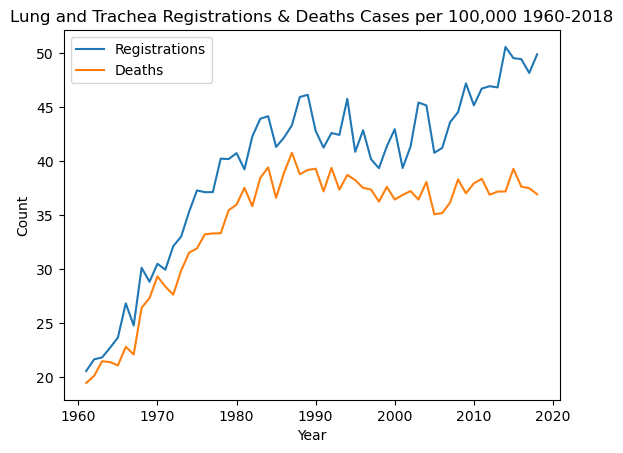

In [34]:
#Viewing Lung & Trachea cancers registrations & deaths per 100,000, interesting seeing how deaths have stayed relataively flat while 
sns.lineplot(data=LungTrach, x='Year', y='Regs:Pop', label='Registrations')
sns.lineplot(data=LungTrach, x='Year', y='Deaths:Pop', label='Deaths')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Lung and Trachea Registrations & Deaths Cases per 100,000 1960-2018") 
plt.show(fig)

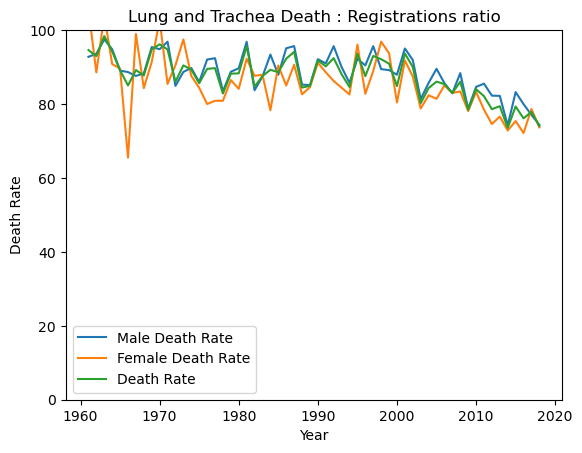

In [35]:
#Ratio of deaths to registrations by year for Lung & Trachea cancers, however appreciate that this is not going to be accurate as given each 
#given death will be some period of time after its registration, leading to some ratios to go over 1
#Interesting to see how much different years trends match for both sexes, indicating that there may be some potential environmental trigger 
#causing a higher death rate (higher than average temperatures would be one possiblity, would be interesting to map annual temperatures vs this graph)

plt.ylim(0, 100)
sns.lineplot(data=LungTrach, x='Year', y='Male_Death_Rate', label = 'Male Death Rate')
sns.lineplot(data=LungTrach, x='Year', y='Female_Death_Rate', label = 'Female Death Rate')
sns.lineplot(data=LungTrach, x='Year', y='Death_Rate', label = 'Death Rate')
plt.legend()

plt.xlabel("Year")
plt.ylabel("Death Rate")
plt.title("Lung and Trachea Death : Registrations ratio") 
plt.show(fig)

In [36]:
#Items to investigate:
#1. Change in screening / cancer registrations in early 1990s in New Zealand
#2. Compare Lung & Trachea cancer deaths and registrations in New Zealand against average temperatures for each year 
#3. See if trends in smoking may explain sudden rise in female Lung & Trachea registrations & deaths, may this be a delayed increase
#   which will peak and begin to drop due to the significant drop in smoking in New Zealand?